# Problem Statement

The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

The goal of this project is to build a machine learning model that improve the accuracy of the Zestimate even further by prediction the log-error between their Zestimate and the actual sale price, given all the features of a home.

### Logerror

logerror = log(Zestimate/SalePrice)

For the logerror to be negative, we need Zestimate to be less than Sale Price, resulting in a ratio less than 1. 
This means the Zestimate is underestimating the actual Sale Price. 

If Zestimate is significantly smaller than Sale Price, the logerror will have a larger negative value. 
On the other hand, if Zestimate is close to actual Sale Price., the logerror will approach zero.

# Import Libaries

In [1]:
# Import the libraries we'll use below.
## import necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Gathering

The data contain the full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.
The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

In [2]:
train_df = pd.read_csv(f"./train_2017.csv", parse_dates=["transactiondate"])
print(train_df.shape)
train_df.head()

(77613, 3)


,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


In [3]:
# reading in the 2017 properties .csv file and get some info from it
prop_df = pd.read_csv(f"./properties_2017.csv", low_memory=False)
print(prop_df.shape)
prop_df.head()

(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


# Data Preprocessing

If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.

In [4]:
# creating new column and call it transaction_month.
train_df['transaction_month'] = train_df['transactiondate'].dt.month
train_df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'transaction_month'], dtype='object')

In [5]:
# A parcelid is unqiue to a property. If there a duplicate row then there are multiple transaction for that property.
# If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. 
# By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.
train_df[train_df.duplicated(["parcelid", "transaction_month"],keep=False)]

,parcelid,logerror,transactiondate,transaction_month
4417,11499166,0.010002,2017-01-20,1
4418,11499166,0.006474,2017-01-31,1
23738,17136356,0.035831,2017-04-05,4
23739,17136356,0.035831,2017-04-28,4
31632,14606311,0.034141,2017-05-01,5
31633,14606311,0.034141,2017-05-18,5
33558,14074415,-0.068416,2017-05-05,5
33559,14074415,0.328850,2017-05-12,5
34298,162960529,0.007117,2017-05-09,5
34299,162960529,0.007117,2017-05-26,5


In [6]:
# We're going to choose the simple approach by using the last transaction of the month for each row above as the ground truth.
unique_train_data = train_df.sort_values("transactiondate").drop_duplicates(["parcelid"], keep = "last")
print(unique_train_data.shape)

(77414, 4)


In [7]:
# Now we want to merge the data containing the property's features and the data containing the logerror
full_data = pd.DataFrame()
full_data = pd.merge(prop_df, unique_train_data,on="parcelid",how="left")

In [8]:
print(full_data.shape)
full_data.head()

(2985217, 61)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,transaction_month
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN,NaN,NaT,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN,NaN,NaT,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN,NaN,NaT,NaN


In [9]:
full_data.dtypes.sort_values()

parcelid                              int64
transactiondate              datetime64[ns]
pooltypeid7                         float64
propertylandusetypeid               float64
rawcensustractandblock              float64
                                  ...      
fireplaceflag                        object
propertyzoningdesc                   object
taxdelinquencyflag                   object
propertycountylandusecode            object
hashottuborspa                       object
Length: 61, dtype: object

### Data Cleaning

In [10]:
# First off, we only want the row containing the logerror since that is what we are predicting
full_data= full_data.dropna(subset=['logerror'])
full_data.shape

(77414, 61)

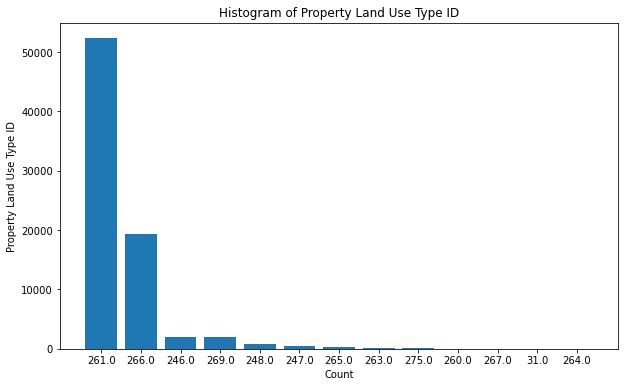

In [11]:
# Based on the data dictionary, 'propertylandusetypeid' is the type of the property
value_counts = full_data['propertylandusetypeid'].value_counts()

plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the horizontal bar plot
plt.bar(value_counts.index.astype(str), value_counts.values)

# Optional: Set labels and title
plt.xlabel('Count')
plt.ylabel('Property Land Use Type ID')
plt.title('Histogram of Property Land Use Type ID')

plt.show()

In [12]:
# Based on the histogram above, PropertyLandUseTypeID 261 contain the most rows. 
# We will be focusing only on this property type so that our model will yeild the best accuracy.
full_data = full_data[full_data['propertylandusetypeid']== 261]
print(full_data['propertylandusetypeid'].unique())
print(full_data.shape)

[261.]
(52320, 61)


In [13]:
def Get_Null_Percentage(df):
    return (df.isnull().sum() / len(df)) *100

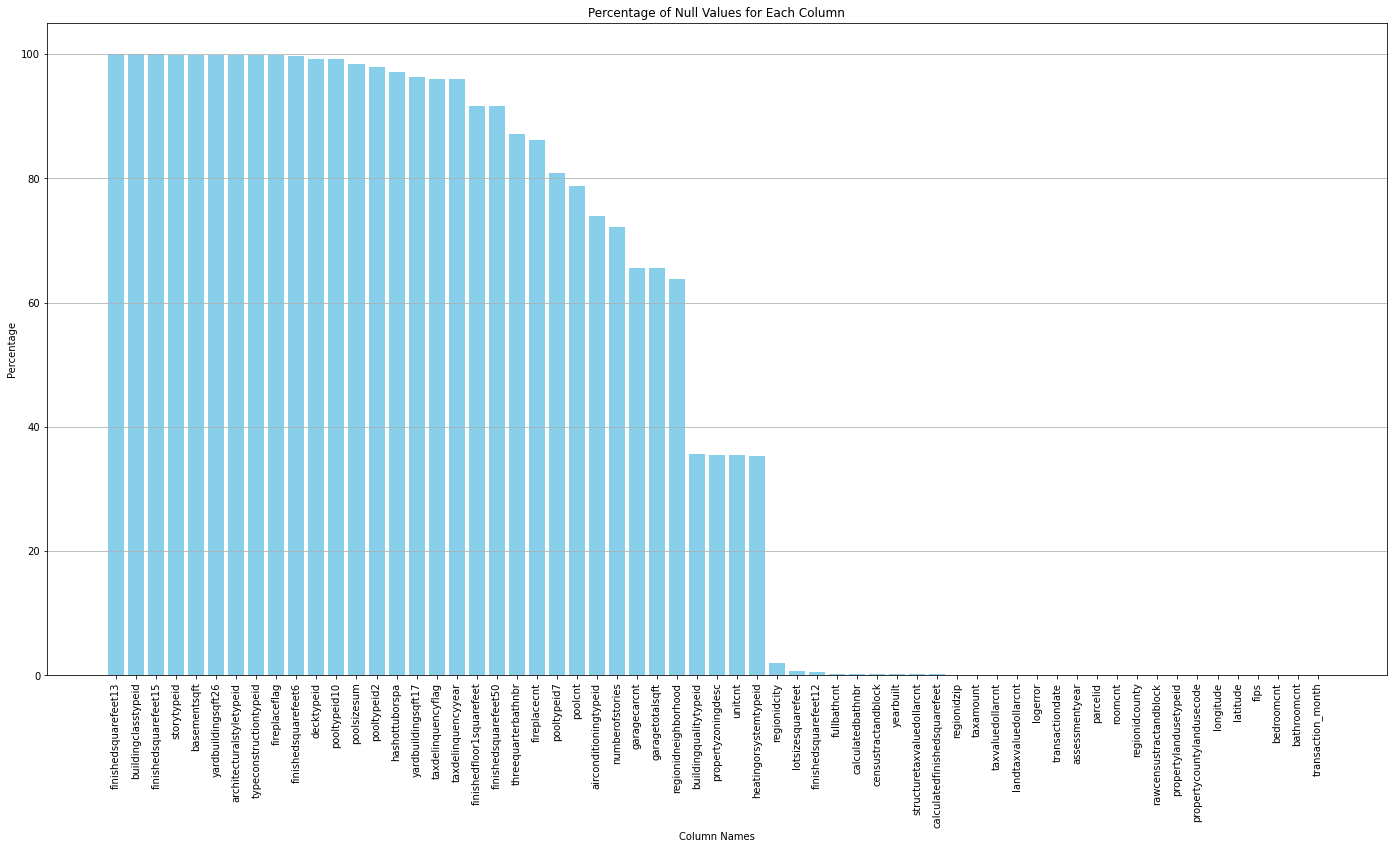

In [14]:
null_percentage = Get_Null_Percentage(full_data)
null_percentage_sorted = null_percentage.sort_values(ascending=False)

# Plot a bar chart
plt.figure(figsize=(24, 12))
plt.bar(null_percentage_sorted.index, null_percentage_sorted.values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Column Names')
plt.ylabel('Percentage')
plt.title('Percentage of Null Values for Each Column')
plt.grid(axis='y')
plt.show()

In [15]:
# Drop columns that contain duplicated information as the other columns
columns_to_drop = ['regionidcity', 'regionidneighborhood', 'regionidzip', 'storytypeid', 
                   'typeconstructiontypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 
                   'finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet50', 
                   'finishedsquarefeet6', 'buildingclasstypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10',
                  'taxvaluedollarcnt', 'numberofstories', 'assessmentyear', 'propertylandusetypeid']
full_data.drop(columns_to_drop, axis=1, inplace=True)
print(full_data.shape)

(52320, 42)


In [16]:
# Replace null values with appropriate default value based on the dictionary or mean.
fill_values = {'airconditioningtypeid': 5, 'architecturalstyletypeid': 19, 'basementsqft': 0, 'garagecarcnt': 0, 'garagetotalsqft': 0 ,
               'heatingorsystemtypeid' : 14, 'poolcnt': 0, 'buildingqualitytypeid': full_data['buildingqualitytypeid'].mean(),
               'decktypeid': 0, 'poolsizesum': 0, 'propertyzoningdesc': 'LAR1', 'threequarterbathnbr': 0,
               'fireplacecnt': 0, 'yardbuildingsqft17': 0, 'yardbuildingsqft26': 0, 'taxdelinquencyyear': 0, 'fireplaceflag': 0,
              'hashottuborspa': 0, 'taxdelinquencyflag': 0, 'unitcnt': 1}

full_data.fillna(fill_values, inplace=True)

In [17]:
# since there is only 66 and nan for this column, we will replace nan with 0 and 66 with 1.
full_data['decktypeid'].replace(66, 1, inplace = True)
full_data['fireplaceflag'].replace(True, 1, inplace=True)
full_data['hashottuborspa'].replace(True, 1, inplace=True)
full_data['taxdelinquencyflag'].replace('Y', 1, inplace=True)

In [18]:
# Drop rows with missing values in specific columns
full_data.dropna(subset=['landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount', 
                         'censustractandblock','propertycountylandusecode', 'calculatedfinishedsquarefeet', 
                         'finishedsquarefeet12', 'lotsizesquarefeet', 'yearbuilt', 'fullbathcnt'], inplace=True)
print(full_data.shape)

(51530, 42)


In [19]:
# Drop rows with incorrect lengths in 'censustractandblock' column
full_data = full_data[full_data['censustractandblock'].astype(str).str.len() == 16]

In [20]:
Get_Null_Percentage(full_data)

parcelid                        0.0
airconditioningtypeid           0.0
architecturalstyletypeid        0.0
basementsqft                    0.0
bathroomcnt                     0.0
bedroomcnt                      0.0
buildingqualitytypeid           0.0
decktypeid                      0.0
calculatedfinishedsquarefeet    0.0
finishedsquarefeet12            0.0
fips                            0.0
fireplacecnt                    0.0
fullbathcnt                     0.0
garagecarcnt                    0.0
garagetotalsqft                 0.0
hashottuborspa                  0.0
heatingorsystemtypeid           0.0
latitude                        0.0
longitude                       0.0
lotsizesquarefeet               0.0
poolcnt                         0.0
poolsizesum                     0.0
propertycountylandusecode       0.0
propertyzoningdesc              0.0
rawcensustractandblock          0.0
regionidcounty                  0.0
roomcnt                         0.0
threequarterbathnbr         

### Normalize Data

In [21]:
one_hot_columns = [
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'decktypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertycountylandusecode',
    'propertyzoningdesc',  # this one has 1257 unique vals
    'regionidcounty'
    ]

# Already mapped to 0s and 1s
flag_columns = [
    'taxdelinquencyflag',
    'fireplaceflag',
    'hashottuborspa'
]

datetime_columns = [
    'transactiondate'
]

numerical_columns = [
    'parcelid',
    'basementsqft',
    'bathroomcnt',
    'bedroomcnt',
    'buildingqualitytypeid',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet12',
    'fireplacecnt',
    'fullbathcnt',
    'garagecarcnt',
    'garagetotalsqft',
    'latitude',
    'longitude',
    'lotsizesquarefeet',
    'poolcnt',
    'poolsizesum',
    'rawcensustractandblock',
    'roomcnt',
    'threequarterbathnbr',
    'unitcnt',
    'yardbuildingsqft17',
    'yardbuildingsqft26', 
    'yearbuilt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount',
    'taxdelinquencyyear',
    'censustractandblock',
    'logerror',
    'transaction_month'
    ]

In [22]:
# one hot encode the columns that need to be one hot encoded
def one_hot_encode_column(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    '''
    Use sklearns one_hot_encoder to sparse one hot encode a column in place.
    '''
    from sklearn.preprocessing import OneHotEncoder
    unique_vals = df[column_name].unique()
    print(f'Column = {column_name} has {len(unique_vals)} unique values. One hot encoding them...')

    encoder = OneHotEncoder(sparse=False)
    encoded_categories = encoder.fit_transform(df[[column_name]])
    sparse_encoded_categories = np.argmax(encoded_categories, axis=1).tolist()
    df[column_name] = sparse_encoded_categories
    return df


for col in one_hot_columns:
    one_hot_encode_column(full_data, col)

Column = airconditioningtypeid has 4 unique values. One hot encoding them...
Column = architecturalstyletypeid has 6 unique values. One hot encoding them...
Column = decktypeid has 2 unique values. One hot encoding them...
Column = fips has 3 unique values. One hot encoding them...
Column = heatingorsystemtypeid has 10 unique values. One hot encoding them...
Column = propertycountylandusecode has 22 unique values. One hot encoding them...
Column = propertyzoningdesc has 1257 unique values. One hot encoding them...


/Users/mengkry/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mengkry/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mengkry/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mengkry/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sp

Column = regionidcounty has 3 unique values. One hot encoding them...


/Users/mengkry/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
# convert datetime to seconds(float64)
# Create a reference date
reference_date = pd.Timestamp('1970-01-01')

# Replace datetime with float representation (e.g., seconds since the reference date)
full_data['transactiondate'] = (full_data['transactiondate'] - reference_date).dt.total_seconds()

full_data['transactiondate'].head()

349    1.497485e+09
355    1.501027e+09
383    1.501200e+09
423    1.499386e+09
429    1.501200e+09
Name: transactiondate, dtype: float64

In [24]:
full_data=full_data.astype('float64')

In [25]:
full_data.dtypes.sort_values()

parcelid                        float64
propertyzoningdesc              float64
rawcensustractandblock          float64
regionidcounty                  float64
roomcnt                         float64
threequarterbathnbr             float64
unitcnt                         float64
yardbuildingsqft17              float64
yardbuildingsqft26              float64
yearbuilt                       float64
fireplaceflag                   float64
structuretaxvaluedollarcnt      float64
landtaxvaluedollarcnt           float64
taxamount                       float64
taxdelinquencyflag              float64
taxdelinquencyyear              float64
censustractandblock             float64
logerror                        float64
propertycountylandusecode       float64
poolsizesum                     float64
poolcnt                         float64
lotsizesquarefeet               float64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64


# Data Exploration and Visualization

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc32e51e4c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc32e51eb20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc32e51e1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc32e52d040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc32e52d310>],
 'means': []}

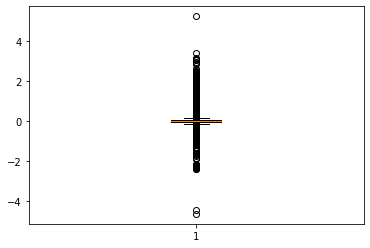

In [26]:
plt.boxplot(full_data['logerror'])

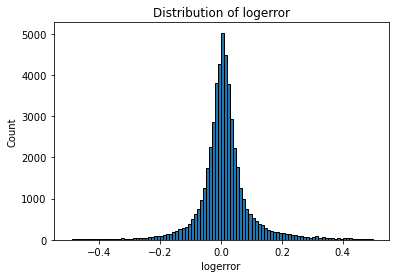

In [27]:
# plot the logerror distribution
plt.hist(full_data['logerror'], bins=100, range=(-0.5, 0.5), edgecolor='black')
plt.title('Distribution of logerror')
plt.xlabel('logerror')
plt.ylabel('Count')
plt.show()

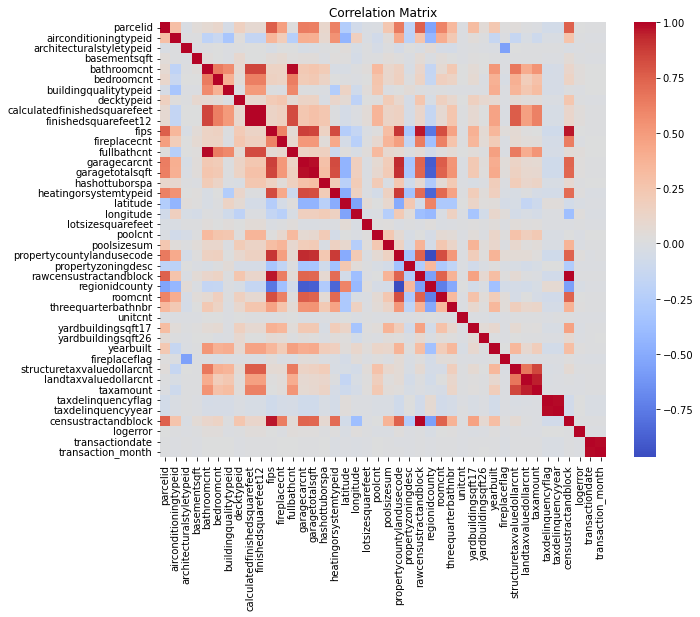

In [28]:
corr = full_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [29]:
logerror_corr_sorted = corr['logerror'].drop('logerror').sort_values()

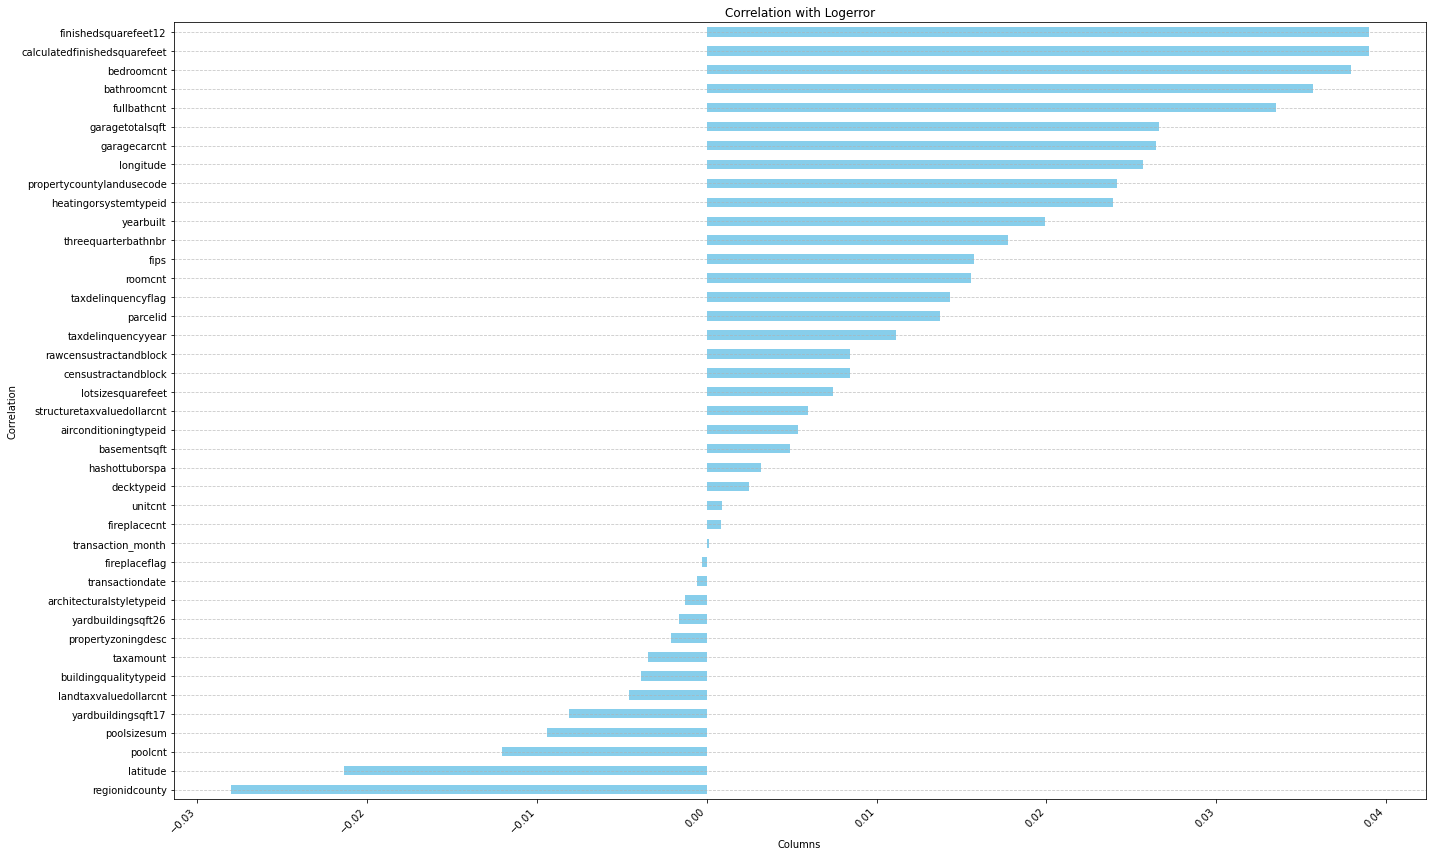

In [30]:
# Create the bar plot
plt.figure(figsize=(20, 12))  # You can adjust the size (width, height) as per your requirement
logerror_corr_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.title('Correlation with Logerror')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
threshold = 0.15
filtered_data = full_data[(full_data['logerror'] > -threshold) & (full_data['logerror'] < threshold)]
filtered_data.shape

(46327, 42)

## Baseline Model

Mean Squared Error (MSE):

MSE measures the average squared difference between the predicted values and the true values of the target variable.
A lower MSE value indicates that the model's predictions are closer to the actual values, which is desirable.
In the context of the provided result (MSE ≈ 0.0325), it means that, on average, the squared difference between the predicted values and the true values is approximately 0.0325. Lower MSE values are generally better.
Root Mean Squared Error (RMSE):

RMSE is the square root of the MSE, and it provides a measure of the average absolute difference between the predicted values and the true values of the target variable.
Like MSE, a lower RMSE value indicates that the model's predictions are closer to the actual values.
In the context of the provided result (RMSE ≈ 0.1802), it means that, on average, the absolute difference between the predicted values and the true values is approximately 0.1802. Lower RMSE values are better.
Mean Absolute Error (MAE):

MAE measures the average absolute difference between the predicted values and the true values of the target variable.
It is another metric that indicates how well the model's predictions match the actual values.
In the context of the provided result (MAE ≈ 0.0791), it means that, on average, the absolute difference between the predicted values and the true values is approximately 0.0791. Lower MAE values are better.
R-squared (R2) Score:

R-squared is a statistical measure that represents the proportion of the variance in the target variable that is explained by the regression model.
It ranges from -∞ to 1, with 1 indicating that the model explains all the variance in the target variable and values close to 0 or negative indicating poor model fit.
In the context of the provided result (R2 ≈ -0.0557), it means that the model does not explain the variance in the target variable well, and it is performing worse than a model that predicts the mean of the target variable. A negative R-squared suggests that the model's predictions are worse than simply using the mean of the target variable.

0.0025686593658697573
-0.00019529923446071074
Mean Squared Error: 0.00257
R-squared: -0.00020
Percent Improvement over Baseline: 0%


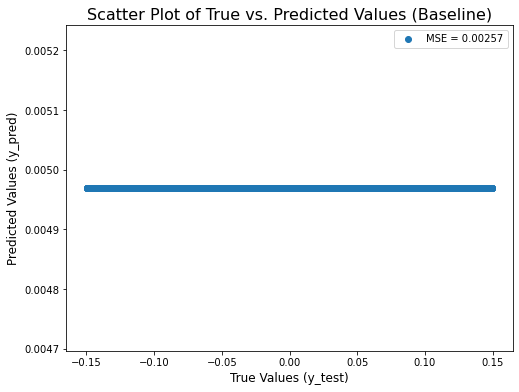

In [32]:
# For baseline, predict the average label value

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features (X) and target (y)
# Using the columns with high correlation to logerror.
X = filtered_data.drop(columns=['logerror'])
y = filtered_data['logerror']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_prediction = np.zeros(y_test.shape) + np.mean(y_train)
mse = mean_squared_error(y_test, baseline_prediction)
r2 = r2_score(y_test, baseline_prediction)
pct_improvement = 0
print(mse)
print(r2)

print("Mean Squared Error:", f'{mse:0.5f}')
print("R-squared:", f'{r2:0.5f}')
print("Percent Improvement over Baseline:", f'{pct_improvement}%')

plt.figure(figsize=(8,6))
lab1 = plt.scatter(y_test,baseline_prediction, label=f'MSE = {mse:.5f}')
# Add title and labels for x and y-axis
plt.title('Scatter Plot of True vs. Predicted Values (Baseline)', fontsize=16)
plt.xlabel('True Values (y_test)', fontsize=12)
plt.ylabel('Predicted Values (y_pred)', fontsize=12)
plt.legend(handles=[lab1])

plt.show()


## Linear Regression Model

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features (X) and target (y)
# Using the columns with high correlation to logerror.
X = filtered_data.drop(columns=['logerror'])
y = filtered_data['logerror']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_test, y_pred)
baseline_pred = np.zeros(y_test.shape) + np.mean(y_train)
baseline_mse = mean_squared_error(baseline_pred, y_test)
pct_improvement = ((baseline_mse-mse)/baseline_mse * 100)

print("Mean Squared Error (MSE):", f'{mse:.5f}')
print("R-squared (R2) Score:", f'{r2:.5f}')
print("Percent Improvement over Baseline", f'{pct_improvement:.4f}%')

Mean Squared Error (MSE): 0.00252
R-squared (R2) Score: 0.02033
Percent Improvement over Baseline 2.0523%


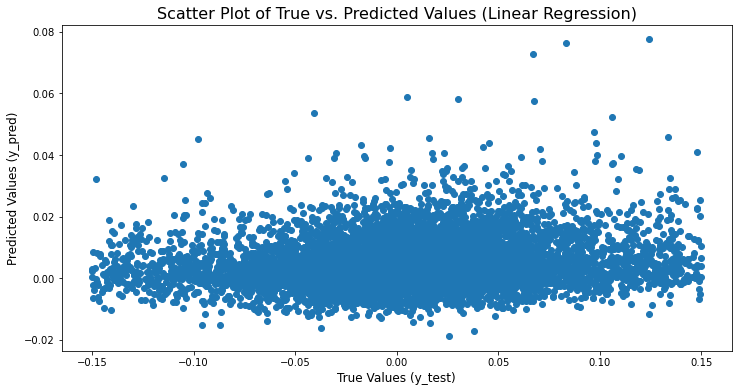

In [34]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)
# Add title and labels for x and y-axis
plt.title('Scatter Plot of True vs. Predicted Values (Linear Regression)', fontsize=16)
plt.xlabel('True Values (y_test)', fontsize=12)
plt.ylabel('Predicted Values (y_pred)', fontsize=12)

plt.show()

Text(0.5, 0, 'Coefficient Value')

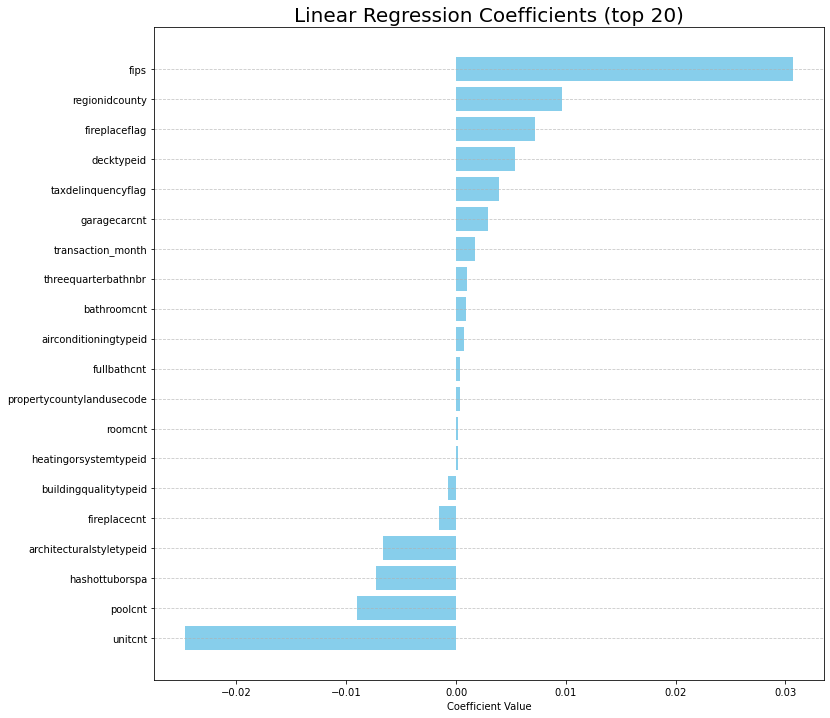

In [35]:
coefs = list(model.coef_)
colnames = list(X.columns)
linreg_coef_names = list(zip(coefs, colnames))
linreg_coef_names.sort()

y = [i[0] for i in linreg_coef_names if abs(i[0]) > 1e-4]
lab = [i[1] for i in linreg_coef_names if abs(i[0]) > 1e-4]


plt.figure(figsize=(12,12))
plt.barh([j for j in range(len(y))], y, tick_label=lab, color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Linear Regression Coefficients (top 20)', fontsize=20)
plt.xlabel('Coefficient Value')

### RandomForest Model

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Separate features (X) and target (y)
X = filtered_data.drop(columns=['logerror'])
y = filtered_data['logerror']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
baseline_pred = np.zeros(y_test.shape) + np.mean(y_train)
baseline_mse = mean_squared_error(baseline_pred, y_test)
pct_improvement = ((baseline_mse-mse)/baseline_mse * 100)

print("Mean Squared Error (MSE):", mse)
print("Train mse:", train_mse)
print("R-squared (R2) Score:", r2)
print("pct improvement", pct_improvement)

Mean Squared Error (MSE): 0.0025602290539623413
Train mse: 0.00036113942491485126
R-squared (R2) Score: 0.003087330783717035
pct improvement 0.32819890482292124


### CNN

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-08-26 17:14:53.514696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

    for hidden_layer in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(hidden_layer, activation=activation))
        
    model.add(tf.keras.layers.Dense(1))
    
    # Define the optimizer
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss='mean_squared_error')
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    model.summary()
    return model

In [40]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

    # Build the model.
    model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

    # Separate features (X) and target (y)
    X = full_data.drop(columns=['logerror'])
    Y = full_data['logerror']

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the model.
    print('Training...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final test
    # Retrieve the training metrics (after each train epoch) and the final test loss.
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    loss = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['loss']
    return loss

train_and_evaluate([], 'tanh', 'SGD', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training...


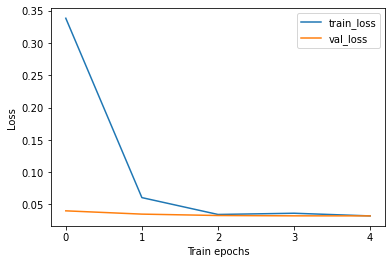

Test Loss:  0.06428901851177216
---------------------------------------------------------------------------
train_and_evaluate([], 'relu', 'SGD', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training...


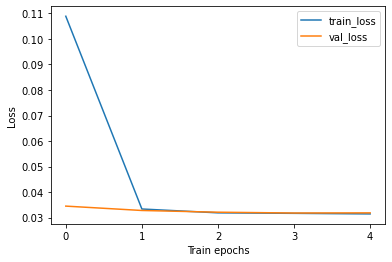

Test Loss:  0.049175988882780075
---------------------------------------------------------------------------
train_and_evaluate([], 'relu', 'Adam', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training...


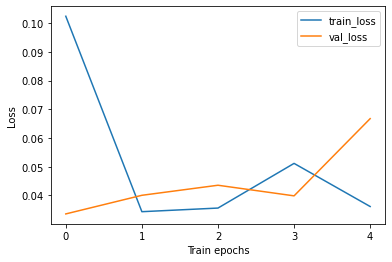

Test Loss:  0.040568117052316666
---------------------------------------------------------------------------
train_and_evaluate([128], 'relu', 'Adam', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 128)               5376      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
Training...


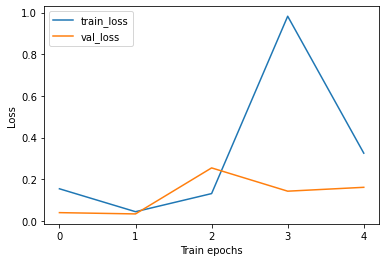

Test Loss:  3.6543047428131104
---------------------------------------------------------------------------
train_and_evaluate([256,128], 'relu', 'Adam', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 256)               10752     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,777
Trainable params: 43,777
Non-trainable params: 0
_________________________________________________________________
Training...


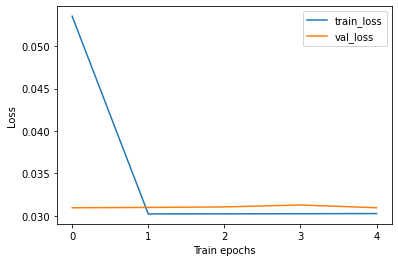

Test Loss:  0.030822191387414932
---------------------------------------------------------------------------
train_and_evaluate([], 'tanh', 'SGD', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training...


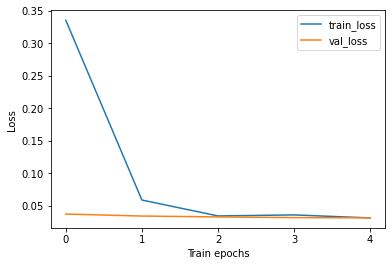

Test Loss:  0.03635312244296074
---------------------------------------------------------------------------
train_and_evaluate([], 'relu', 'SGD', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training...


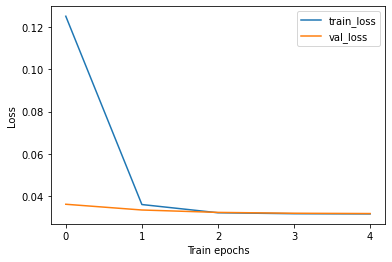

Test Loss:  0.049539703875780106
---------------------------------------------------------------------------
train_and_evaluate([], 'relu', 'Adam', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training...


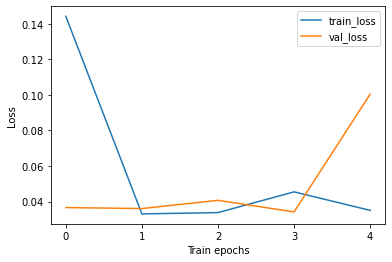

Test Loss:  0.04188218340277672
---------------------------------------------------------------------------
train_and_evaluate([128], 'relu', 'Adam', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 128)               5376      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
Training...


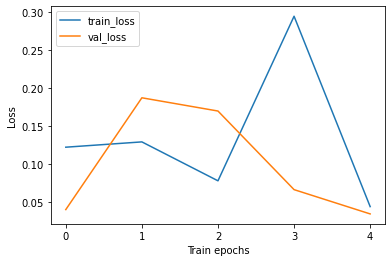

Test Loss:  0.032620977610349655
---------------------------------------------------------------------------
train_and_evaluate('[256,128], 'relu', 'Adam', 0.01) => 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41)                0         
                                                                 
 dense (Dense)               (None, 256)               10752     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,777
Trainable params: 43,777
Non-trainable params: 0
_________________________________________________________________
Training...


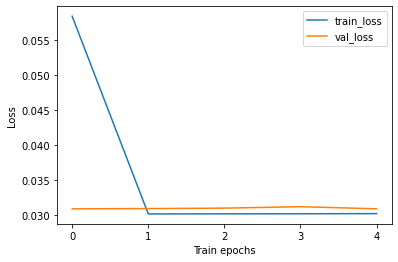

Test Loss:  0.0308119785040617


In [41]:
print("train_and_evaluate([], 'tanh', 'SGD', 0.01) => ")
print('Test Loss: ',train_and_evaluate([], 'tanh', 'SGD', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([], 'relu', 'SGD', 0.01) => ")
print('Test Loss: ',train_and_evaluate([], 'relu', 'SGD', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([], 'relu', 'Adam', 0.01) => ")
print('Test Loss: ', train_and_evaluate([], 'relu', 'Adam', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([128], 'relu', 'Adam', 0.01) => ")
print('Test Loss: ',train_and_evaluate([128], 'relu', 'Adam', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([256,128], 'relu', 'Adam', 0.01) => ")
print('Test Loss: ',train_and_evaluate([256,128], 'relu', 'Adam', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([], 'tanh', 'SGD', 0.01) => ")
print('Test Loss: ',train_and_evaluate([], 'tanh', 'SGD', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([], 'relu', 'SGD', 0.01) => ")
print('Test Loss: ',train_and_evaluate([], 'relu', 'SGD', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([], 'relu', 'Adam', 0.01) => ")
print('Test Loss: ',train_and_evaluate([], 'relu', 'Adam', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate([128], 'relu', 'Adam', 0.01) => ")
print('Test Loss: ',train_and_evaluate([128], 'relu', 'Adam', 0.01))
print('---------------------------------------------------------------------------')
print("train_and_evaluate('[256,128], 'relu', 'Adam', 0.01) => ")
print('Test Loss: ',train_and_evaluate([256,128], 'relu', 'Adam', 0.01))

# XGBoost Model

In [43]:
threshold = 0.15
filtered_data = full_data[(full_data['logerror'] > -threshold) & (full_data['logerror'] < threshold)]
filtered_data.shape

(46327, 42)

pct improvement 2.863056580316311
0.0024946299955409196
0.028630565803163144
2.863056580316311
Mean Squared Error (MSE): 0.0025
Train MSE: 0.0025
Root Mean Squared Error (RMSE): 0.0499
Mean Absolute Error (MAE): 0.0371
R-squared (R2) Score: 0.0286


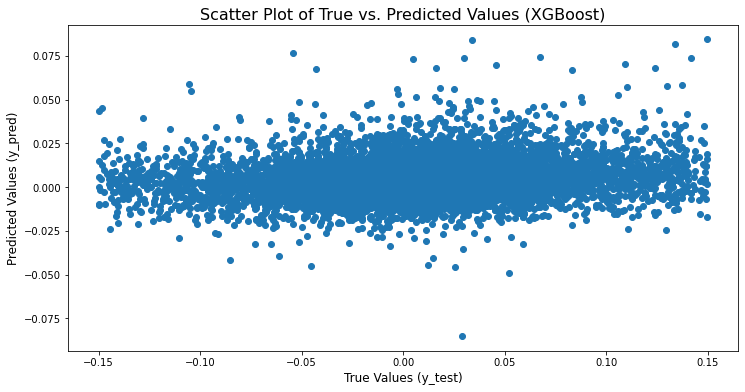

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = filtered_data.drop(columns=['logerror'])
y = filtered_data['logerror'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,  random_state=42)

# Create and fit the XGBoost regression model
xgb_model = xgb.XGBRegressor(n_estimators=1024,
                             max_depth=2,
                             learning_rate=0.1,
                             random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
baseline_pred = np.zeros(y_test.shape) + np.mean(y_test)
baseline_mse = mean_squared_error(baseline_pred, y_test)
pct_improvement = ((baseline_mse-mse)/baseline_mse * 100)
print("pct improvement", pct_improvement)

print(mse)
print(r2)
print(pct_improvement)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Train MSE: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)
# Add title and labels for x and y-axis
plt.title('Scatter Plot of True vs. Predicted Values (XGBoost)', fontsize=16)
plt.xlabel('True Values (y_test)', fontsize=12)
plt.ylabel('Predicted Values (y_pred)', fontsize=12)

plt.show()

Text(0.5, 0, 'Feature Importance')

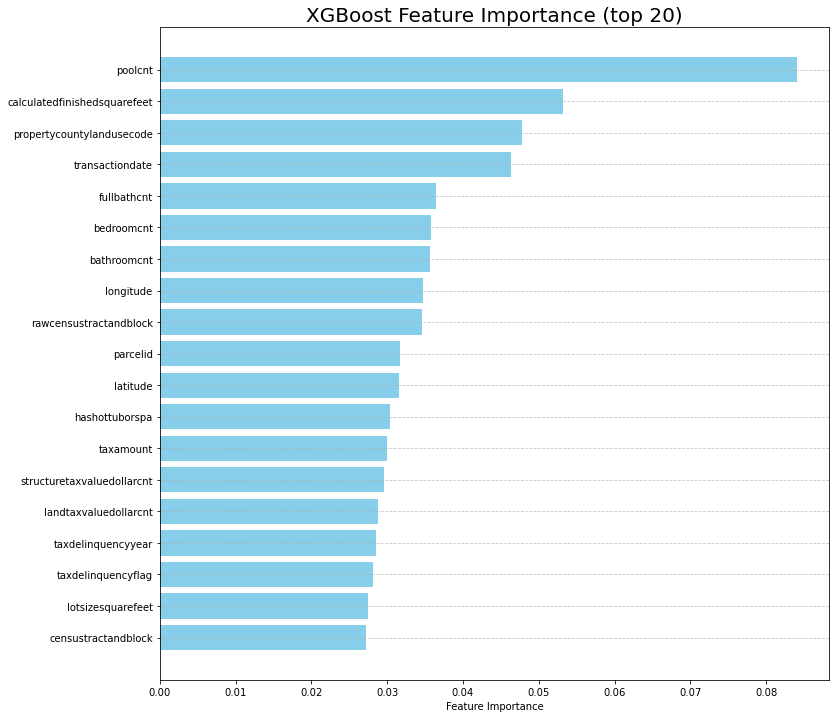

In [45]:
fi = xgb_model.feature_importances_
fn = xgb_model.feature_names_in_

xgb_coef_names = list(zip(fi, fn))
xgb_coef_names.sort()
xgb_coef_names

thresh = 0.026
y = [i[0] for i in xgb_coef_names if i[0] > thresh]
lab = [i[1] for i in xgb_coef_names if i[0] > thresh]

plt.figure(figsize=(12,12))
plt.barh([j for j in range(len(y))], y, tick_label=lab, color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('XGBoost Feature Importance (top 20)', fontsize=20)
plt.xlabel('Feature Importance')

# KNN Model

In [46]:
X = filtered_data
y = filtered_data['logerror'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,  random_state=42)

from sklearn.neighbors import KNeighborsRegressor

# Create a KNeighborsRegressor object
knn_model = KNeighborsRegressor(n_neighbors=256)

# Fit the model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)
y_train_pred = knn_model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
baseline_pred = np.zeros(y_test.shape) + np.mean(y_test)
baseline_mse = mean_squared_error(baseline_pred, y_test)
pct_improvement = ((baseline_mse-mse)/baseline_mse * 100)

print(mse)
print(r2)
print(pct_improvement)
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"R-squared (R2) Score: {r2:.5f}")
print("pct improvement", pct_improvement)

0.002536367659148513
0.012378580235894776
1.2378580235894696
Mean Squared Error (MSE): 0.00254
R-squared (R2) Score: 0.01238
pct improvement 1.2378580235894696


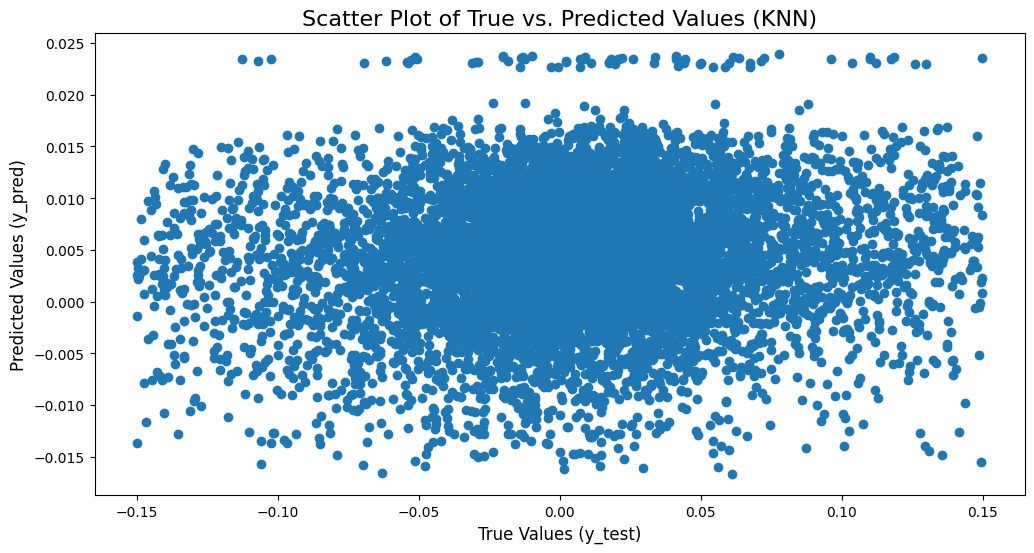

In [264]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)
# Add title and labels for x and y-axis
plt.title('Scatter Plot of True vs. Predicted Values (KNN)', fontsize=16)
plt.xlabel('True Values (y_test)', fontsize=12)
plt.ylabel('Predicted Values (y_pred)', fontsize=12)

plt.show()